# New York City Taxi Trip Duration
Regression: Tabular data

### A Practical Guide to NY Taxi Data
(원본 커널) https://www.kaggle.com/onlyshadow/a-practical-guide-to-ny-taxi-data-0-379 <br>
(참고 한글 커널) https://right1203.github.io/study/2018/01/31/new-york-city-taxi-trip/ <br>

### Problem and Data Explanation
대회목적 : 뉴욕에서의 택시 여행 기간을 예측하는 모델을 만드는것

### Data fields
* id - a unique identifier for each trip
* vendor_id - a code indicating the provider associated with the trip record
* pickup_datetime - date and time when the meter was engaged
* dropoff_datetime - date and time when the meter was disengaged
* passenger_count - the number of passengers in the vehicle (driver entered value)
* pickup_longitude - the longitude where the meter was engaged
* pickup_latitude - the latitude where the meter was engaged
* dropoff_longitude - the longitude where the meter was disengaged
* dropoff_latitude - the latitude where the meter was disengaged
* store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* trip_duration - duration of the trip in seconds


-------------------------------------
## what I learned
* 날짜 데이터를 csv파일 불러올때부터 date time으로 인식하게 불러오기
    * pd.read_csv(,parse_dates['컬럼 이름'])
    * to_datetime으로 변경해줘도 됨.
* datetime.strptime
    * 날짜를 나타내는 문자열을 반환. (ex. January 01 2016 을 2016,1,1 로 변환)
* map함수와 lambda함수
    * lambda함수는 익명함수이기 때문에 한번 쓰이고 다음줄로 넘어가는 힙 메모리 영역에서 증발
    * map함수는 함수에 의해 수행된 결과를 묶어서 map iterator객체로 리턴
        * 즉, map (f, iterable) 로 반복 가능한 iterable자료형이 있어야 한다.
* 자료형 series의 특징
    * Series의 특징은 값과 함께, 우리가 원하는 index를 입력할 수 있다.
* 위도,경도 데이터로 Distance를 구하는 여러 방법
    * Haversine distance
    * Manhattan distance
    * Bearing
* vstack() 
    * vstack 명령은 열의 수가 같은 두 개 이상의 배열을 위아래로 연결하여 행의 수가 더 많은 배열을 만든다. 연결할 배열은 마찬가지로 하나의 리스트에 담아야 한다.
    * vstack 안에 괄호 두개로 감싸야 함 (())
* hstack()
    * hstack 명령은 행의 수가 같은 두 개 이상의 배열을 옆으로 연결하여 열의 수가 더 많은 배열을 만든다. 연결할 배열은 하나의 리스트에 담아야 한다.
* for문으로 반복되는 subplot 그리는 방법
    * for i in range(10) , 여기서 i는 subplot 개수
    * 특정 조건에 맞는 값을 반복하기위한 변수 생성 ex) tmp = data[data.column ==i]
    * 원하는 그래프 그리기 ex) plt.scatter(x축, y축)
* 행에 하나라도 missing value가 있는경우 카운트
    * sum(data.isnull().any(axis=1))
* Outlier를 확인할 수 있는 시각화 방법
    * scatter-plot, box-plot, dist-plot

* pd.get_dummies 활용
    * 범주형(categorical)데이터를 one-hot-encoding하는 방법
* np.all() 
    *  배열의 각 원소들을 일일히 비교하는 것이 아니라, 배열의 모든 원소가 다 같은지 알고 싶다면 all 명령어 사용
* keys()
    * dataframe.keys() 하면 columns를 산출하고, series.keys() 하면 index값 산출
    
### Machine-Learning model
* Bagging, Boosting
* XGBoost model
* cross-validation
* feature-importance

## Data-Preprocessing flow
1) 날짜와 시간이 하나의 컬럼에 있는 데이터를 각각 다른 컬럼으로 값 분리<br>
* 2016-06-30 23:59:58 <br>
    
2) Time and weekend Data
* rest_day 인지 weekday인지에 따라 True,False값 대입 

3) Distance Data (OSRM data)
* map, lambda 함수 활용해서 행별로 돌면서 횟수 카운트해서 새로운 컬럼 생성.
    * left|straight|right|straight|arrive
        * 예를들어, left 개수 right개수 이런 것.
    
4) 위도, 경도 정보로 k-means clustering활용하여 여러 위치를 10개 그룹으로 나눠보고 시각화
* hstack, vstack 으로 데이터 모양 만들기

5) 날씨 정보 
* 눈이오는 경우 (Event컬럼이 'snow') 1로 변환
    * 명목형 변수를 수치형으로 바꿀때 1 을 곱해서 처리
        * 1*(weather.Events=='Snow') + 1*(weather.Events=='Fog\n\t,\nSnow')
        
6) 변수 조합을 통해 관계 살펴보기
* pickup시간대 별 trip_duration (출근,퇴근시간일수록 다른지)
* 월별 trip_duration (월별로 특징이 있는지)
* rest_day 별 trip_duration (쉬는날일수록 다른지)


---------------------------------
## 0. Import Modules and Data

In [12]:
#from importlib import reload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize']=(10,18)
%matplotlib inline
from datetime import datetime
from datetime import date
import xgboost as xgb
from sklearn.cluster import MiniBatchKMeans
import seaborn as sns # plot beautiful charts
import warnings
sns.set()
warnings.filterwarnings('ignore')

In [13]:
data =pd.read_csv('./train.csv', parse_dates=['pickup_datetime'])
test=pd.read_csv('./test.csv', parse_dates=['pickup_datetime'])

In [14]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null datetime64[ns]
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(3), object(3)
memory usage: 122.4+ MB


In [30]:
for df in (data, test):
    df['year']=df['pickup_datetime'].dt.year
    df['month']=df['pickup_datetime'].dt.month
    df['day']=df['pickup_datetime'].dt.day
    df['hr']=df['pickup_datetime'].dt.hour
    df['minute']=df['pickup_datetime'].dt.minute
    df['store_and_fwd_flag']=1*(df.store_and_fwd_flag.values=='Y')   # Y이면 1, N이면 0으로 변환

In [31]:
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,year,month,day,hr,minute
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,0,2016,6,30,23,59
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,0,2016,6,30,23,59
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,0,2016,6,30,23,59
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,0,2016,6,30,23,59
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,0,2016,6,30,23,59


우리는 RMSLE를 우리 score의 metric으로 사용할것이기 때문에, trip_durationd을 log형태로 변환하자. <br>
trip_duration에 outlier가 있으면, 이 변환이 효과를 완화하는데 도움을 줄것이다. <br>
만약 log변환을 하고 나서도 value가 여전히 과도하게 크다면, 우리는 이것이 실제 outlier라고 보다 확실하게 말할 수 있다.

## 1. Features
가장 중요하다고 생각되는 features 는 <br>
1. the pickup time 
2. the trip distance
3. the pickup location

관련없는 정보를 고려하지 않아도 되는, Gradient Boost Tree를 사용할 것이다. <br>
또한 다중공선성은 고려하지 않아도 된다. 그래서 우리는 가능한 많은 feature를 넣을 것이다. <br>
Gradient Boost의 다른 좋은 점은, tree-based 알고리즘이기 때문에 missing values를 신경쓰지 않아도 된다는 점이다.

### 1.1 Pickup Time and Weekend Features
rush hour에는 travel time이 더 길것이고, work day에는 다른 결과를 가져올것이라 생각할 수 있다. <br>
우리는 pickup_datetime으로부터 아래의 feature들을 만들어낼것이다. <br>

1. rest_day : rest day일 경우 True, 아닐경우 False.
2. weekend : weekend일 경우 True, 아닐경우 False.
3. pickup_time : 7:30 am 이면 7.5, 6:45pm 이면 18.75

In [47]:
from datetime import datetime
holiday=pd.read_csv('./NYC_2016Holidays.csv',sep=';')

In [49]:
holiday['Date'] = holiday['Date'].apply(lambda x: x + ' 2016')

In [54]:
holiday.head()

,Day,Date,Holiday
0,Friday,January 01 2016,New Years Day
1,Monday,January 18 2016,Martin Luther King Jr. Day
2,Friday,February 12 2016,Lincoln's Birthday
3,Monday,February 15 2016,Presidents' Day
4,Sunday,May 08 2016,Mother's Day


In [71]:
holidays = [datetime.strptime(holiday.loc[i,'Date'], '%B %d %Y').date() for i in range(len(holiday))]
holidays

[datetime.date(2016, 1, 1),
 datetime.date(2016, 1, 18),
 datetime.date(2016, 2, 12),
 datetime.date(2016, 2, 15),
 datetime.date(2016, 5, 8),
 datetime.date(2016, 5, 30),
 datetime.date(2016, 6, 19),
 datetime.date(2016, 7, 4),
 datetime.date(2016, 9, 5),
 datetime.date(2016, 10, 10),
 datetime.date(2016, 11, 11),
 datetime.date(2016, 11, 24),
 datetime.date(2016, 12, 26),
 datetime.date(2016, 7, 4),
 datetime.date(2016, 11, 8)]

In [59]:
time_data = pd.DataFrame(index = range(len(data)))
time_test = pd.DataFrame(index = range(len(test)))

In [73]:
from datetime import date
def restday(yr,month,day,holidays):
    '''
    Output:
        is_rest : sample이 rest day에 발생했을 경우의 Boolean variable
        is_weekend: sample 이 weekend에 발생했을 경우의 Boolean variable
    '''
    is_rest = [None]*len(yr)     # None값을 year의 길이만큼 대입
    is_weekend=[None]*len(yr)    
    i=0
    for yy,mm,dd in zip(yr,month,day):
        is_weekend[i]=date(yy,mm,dd).isoweekday() in (6,7)   # isoweekday()은 정수로 요일을 반환. 월요일은 1, 일요일은 7
        is_rest[i] = is_weekend[i] or date(yy,mm,dd) in holidays
        i+=1
    return is_rest, is_weekend

In [78]:
# train data
rest_day,weekend = restday(data.year,data.month,data.day,holidays)
time_data = time_data.assign(rest_day=rest_day)
time_data = time_data.assign(weekend=weekend)
### 위의 assign함수로 하는것과 아래는 같은 결과
#time_data['rest_day']=rest_day
#time_data['weekend']=weekend
#time_data['pickup_time']=data.hr+data.minute/60

# test data
rest_day,weekend = restday(test.year,test.month,test.day,holidays)
time_test = time_test.assign(rest_day=rest_day)
time_test = time_test.assign(weekend=weekend)

In [81]:
time_data=time_data.assign(pickup_time= data.hr+data.minute/60)
time_test=time_test.assign(pickup_time=test.hr+test.minute/60)

In [83]:
time_data.to_csv('./time_data.csv', index=False)
time_test.to_csv('./time_test.csv', index=False)

In [84]:
time_data.head()

,rest_day,weekend,pickup_time
0,False,False,17.400000
1,True,True,0.716667
2,False,False,11.583333
3,False,False,19.533333
4,True,True,13.500000


### 1.2 Distance Features


#### 1.2.1 OSRM Features
GPS로부터 얻은 실제 pickup과 dropoff의 위치 차이가 아니라, travel distance가 더 관련성 있는 데이터라고 한다.

In [85]:
# csv파일 불러올때부터 특정 컬럼만 불러오기
fastrout1 = pd.read_csv('./fastest_routes_train_part_1.csv', usecols=['id','total_distance','total_travel_time','number_of_steps','step_direction'])
fastrout2 = pd.read_csv('./fastest_routes_train_part_2.csv', usecols=['id','total_distance','total_travel_time','number_of_steps','step_direction'])
fastrout = pd.concat((fastrout1, fastrout2))
fastrout.head()

,id,total_distance,total_travel_time,number_of_steps,step_direction
0,id2875421,2009.1,164.9,5,left|straight|right|straight|arrive
1,id2377394,2513.2,332.0,6,none|right|left|right|left|arrive
2,id3504673,1779.4,235.8,4,left|left|right|arrive
3,id2181028,1614.9,140.1,5,right|left|right|left|arrive
4,id0801584,1393.5,189.4,5,right|right|right|left|arrive


right turns와 left turns의 수에 대한 feature을 만들것이다. 'slight right'와 'slight left'는 카운트하지 않을 것이다.

In [92]:
# map함수는 데이터 각각에 특정 함수를 적용.
### map(f, iterable) : 함수 (f)와 반복 가능한 (iterable)자료형을 입력으로 받는다.
# lambda를 통해 즉석에서 함수를 만들어서 적용.
right_turn=[]
left_turn=[]
right_turn+= list(map(lambda x:x.count('right')-x.count('slight right'), fastrout.step_direction))   # 여기서 iterable자료형은 fastrout.step_direction값
left_turn += list(map(lambda x:x.count('left')-x.count('slight left'),fastrout.step_direction))

trip_duration과 관련있는 feature들을 결합해보자.

In [105]:
osrm_data=fastrout[['id','total_distance','total_travel_time','number_of_steps']]
osrm_data['right_steps']=right_turn
osrm_data['left_steps']=left_turn
osrm_data.head()

,id,total_distance,total_travel_time,number_of_steps,right_steps,left_steps
0,id2875421,2009.1,164.9,5,1,1
1,id2377394,2513.2,332.0,6,2,2
2,id3504673,1779.4,235.8,4,1,2
3,id2181028,1614.9,140.1,5,2,2
4,id0801584,1393.5,189.4,5,3,1


OSRM 데이터의 행은 1458643개이며, 실제 데이터보다 1개 행이적다. 그래서 이 데이터를 사용하기 위해서는 SQL의 join을 사용하여서 데이터를 접합시켜야 한다.

In [109]:
len(osrm_data)

1458643

In [107]:
len(data)

1458644

In [114]:
data= data.join(osrm_data.set_index('id'), on='id')
data.head(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,year,month,day,hr,minute,total_distance,total_travel_time,number_of_steps,right_steps,left_steps
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,...,2016,3,14,17,24,2009.1,164.9,5.0,1.0,1.0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,...,2016,6,12,0,43,2513.2,332.0,6.0,2.0,2.0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,...,2016,1,19,11,35,11060.8,767.6,16.0,5.0,4.0


테스트 데이터에도 동일한 처리를 한다.

In [133]:
osrm_test=pd.read_csv('./fastest_routes_test.csv')
right_turn= list(map(lambda x:x.count('right')-x.count('slight right'),osrm_test.step_direction))
left_turn = list(map(lambda x:x.count('left')-x.count('slight left'),osrm_test.step_direction))

osrm_test = osrm_test[['id','total_distance','total_travel_time','number_of_steps']]
osrm_test = osrm_test.assign(right_steps=right_turn)
osrm_test = osrm_test.assign(left_steps=left_turn)
osrm_test.head(3)

,id,total_distance,total_travel_time,number_of_steps,right_steps,left_steps
0,id0771704,1497.1,200.2,7,2,3
1,id3274209,1427.1,141.5,2,0,0
2,id2756455,2312.3,324.6,9,4,4


In [135]:
len(test)

625134

In [136]:
len(osrm_test)

625134

In [ ]:
test = test.join(osrm_test.set_index('id'), on='id')

In [138]:
osrm_data = data[['total_distance','total_travel_time','number_of_steps','right_steps','left_steps']]
osrm_test = test[['total_distance','total_travel_time','number_of_steps','right_steps','left_steps']]

In [139]:
data.to_csv('./osrm_data.csv',index=False, columns=['total_distance','total_travel_time','number_of_steps','right_steps','left_steps'])
test.to_csv('./osrm_test.csv',index=False,
            columns = ['total_distance','total_travel_time','number_of_steps','right_steps','left_steps'])

#### 1.2.2 Other Distance Features
1. Haversine distance: the direct distance of two GPS location, taking into account that the earth is round.
2. Manhattan distance: the usual L1 distance, here the haversine distance is used to calculate each coordinate of distance.
3. Bearing: The direction of the trip. Using radian as unit. (I must admit that I am not fully understand the formula. I have starring at it for a long time but can't come up anything. If anyone can help explain that will do me a big favor.)

- 출처 : beluga

In [147]:
def haversine_array(lat1,lng1,lat2,lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))   # dropoff위/경도, pickup위/경도를 np.radians함수로 변경
    AVG_EARTH_RADIUS=6371
    lat= lat2 - lat1
    lng= lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [161]:
List_dist = []
for df in (data,test):
    lat1, lng1, lat2, lng2 = (df['pickup_latitude'].values, df['pickup_longitude'].values, 
                              df['dropoff_latitude'].values,df['dropoff_longitude'].values)
    dist = pd.DataFrame(index=range(len(df)))
    dist = dist.assign(haversind_dist = haversine_array(lat1, lng1, lat2, lng2))
    dist = dist.assign(manhattan_dist = dummy_manhattan_distance(lat1, lng1, lat2, lng2))
    dist = dist.assign(bearing = bearing_array(lat1, lng1, lat2, lng2))
    List_dist.append(dist)   # List_dist에는 train데이터와 test데이터 각각이 들어가있음.
Other_dist_data,Other_dist_test = List_dist   # 각각에 train데이터와 test데이터

In [165]:
Other_dist_data.to_csv('./Other_dist_data.csv', index=False)
Other_dist_test.to_csv('./Other_dist_test.csv',index=False)

### 1.3 Location Features: K-means Clustering
location의 town별로 points를 나누려고 한다. 이것은 google API 또는 OSRM로부터의 몇가지 지리학적 정보를 요구할것이다. <br>
우리 데이터셋에 10개의 kmeans cluster를 셋팅할것이다. <br>
kmeans 는 4-d data를 수행한다. ['pickup_latitude', 'pickup_longitude','dropoff_latitude', 'dropoff_longitude'] <br>

결과 feature는 0,1,2,,,10사이의 categorical value이다. 이 feature를 xgboost에서 쓰려면, 20dummy variables로 변환해야한다. <br>
그렇지 않으면, 모듈은 이것을 numerical로 다룰것이다.

In [170]:
coord_pickup=np.vstack((data[['pickup_latitude','pickup_longitude']].values, test[['pickup_latitude','pickup_longitude']].values))
coord_dropoff = np.vstack((data[['dropoff_latitude', 'dropoff_longitude']].values,                  
                           test[['dropoff_latitude', 'dropoff_longitude']].values))

In [185]:
# (상단) train데이터의 pickup 위도,경도/ train데이터의 dropoff 위도,경도
# (하단) test데이터의 pickup 위도,경도 / test데이터의 dropoff 위도,경도
coords = np.hstack((coord_pickup, coord_dropoff))
sample_ind=np.random.permutation(len(coords))[:500000]       # permutation : 순열 (샘플 500000개 추출하려고한건가)
kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10000).fit(coords[sample_ind])   
for df in (data,test):
    df.loc[:,'pickup_dropoff_loc']=kmeans.predict(df[['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']])

In [195]:
kmean10_data=data[['pickup_dropoff_loc']]
kmean10_test=test[['pickup_dropoff_loc']]

In [197]:
# 특정 컬럼만 csv파일 저장
data.to_csv('./kmean10_data.csv',index=False, columns=['pickup_dropoff_loc'])
test.to_csv('./kmean10_test.csv',index=False, columns=['pickup_dropoff_loc'])

이제 kmeans cluster를 살펴보자. 각각의 cluster는 4d point(longitude/latitude of pickup lacation 과 logitude/latitude of dropoff location) <br>
로 나타나있다. 우선 각 클러스터의 500points 를 그릴것이고, 각각의 plot은 두개의 location (pickup 과 dropoff)이 있다. 

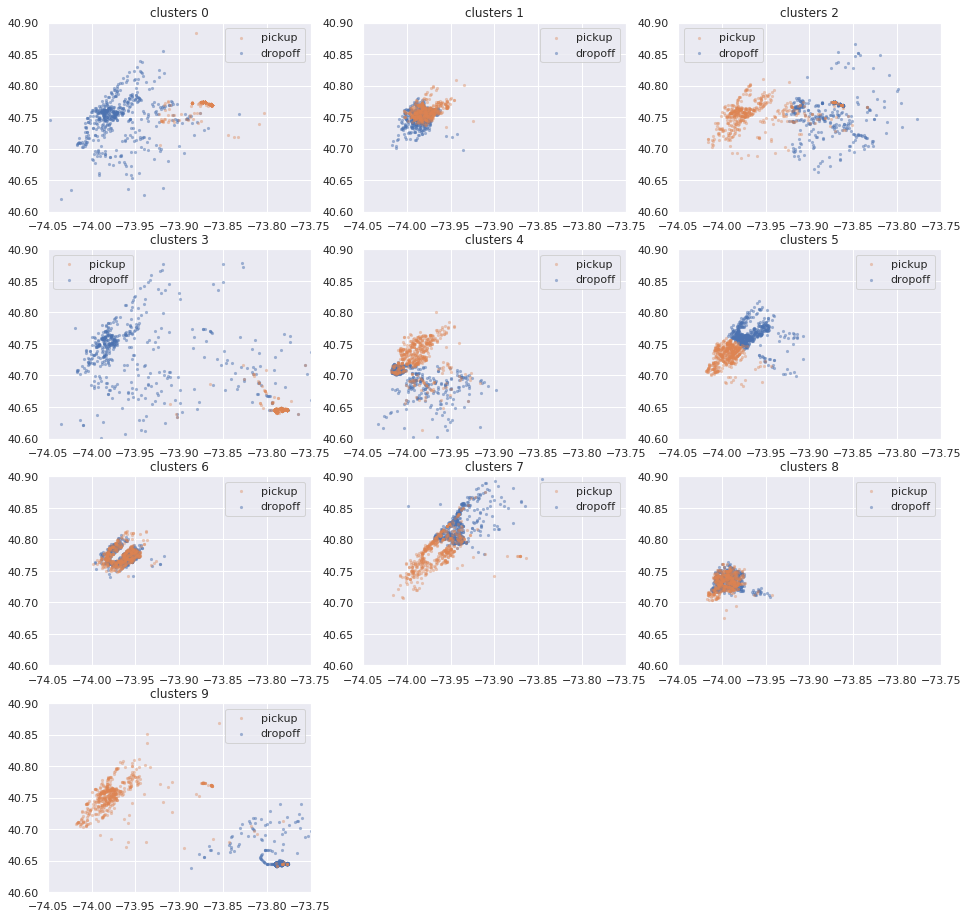

In [210]:
plt.figure(figsize=(16,16))
N =500    # 500개만 plot에 그리기 위함.

for i in range(10):  # i는 0부터 9까지
    plt.subplot(4,3, i+1)   # 4행 3열 총 10개 plot
    
    # pickup_dropoff_loc 이 0일때, 1일때,,, 9일때 각각의 plot을 그림
    tmp_data=data[data.pickup_dropoff_loc==i]   # pickup_dropoff_loc값음 0부터 9까지의 값
    
    # dropoff 에 대한 위도,경도 scatter plot
    drop = plt.scatter(tmp_data['dropoff_longitude'][:N], tmp_data['dropoff_latitude'][:N], s=10, lw=0, alpha=0.5, label='dropoff')
    
    # pickup에 대한 위도,경도 scatter plot
    pick=plt.scatter(tmp_data['pickup_longitude'][:N], tmp_data['pickup_latitude'][:N], s=10, lw=0, alpha=0.4, label='pickup')
    
    plt.xlim([-74.05,-73.75])
    plt.ylim([40.6,40.9])
    plt.legend(handles=[pick,drop])
    plt.title('clusters %d' %i)
    

인상적인 점은<br>
1. short trips은 같은 cluster에 분류되었다.
2. pickup 장소가 dropoff 장소보다 더 밀집되어있다. 이것은 택시 운전기사가 pickup을 하기위해 너무 멀리가기를 원하지 않는다는것을 의미한다. <br>
또는 사람들이 도시로 갈수있는 더 편한 방법이 (기차와같은) 있을수도 있다.


### 1.4 Weather Features

In [213]:
weather=pd.read_csv('./KNYC_Metars.csv',parse_dates=['Time'])
weather.head(3)

,Time,Temp.,Windchill,Heat Index,Humidity,Pressure,Dew Point,Visibility,Wind Dir,Wind Speed,Gust Speed,Precip,Events,Conditions
0,2015-12-31 02:00:00,7.8,7.1,NaN,0.89,1017.0,6.1,8.0,NNE,5.6,0.0,0.8,None,Overcast
1,2015-12-31 03:00:00,7.2,5.9,NaN,0.90,1016.5,5.6,12.9,Variable,7.4,0.0,0.3,None,Overcast
2,2015-12-31 04:00:00,7.2,NaN,NaN,0.90,1016.7,5.6,12.9,Calm,0.0,0.0,0.0,None,Overcast


In [215]:
print('The Events has values {}'.format(str(set(weather.Events))))

The Events has values {'Rain', 'Snow', 'Fog\n\t,\nRain', 'Fog', 'None', 'Fog\n\t,\nSnow'}


In [230]:
weather['snow']= 1*(weather.Events=='Snow') + 1*(weather.Events=='Fog\n\t,\nSnow')
weather['year'] = weather['Time'].dt.year
weather['month'] = weather['Time'].dt.month
weather['day'] = weather['Time'].dt.day
weather['hr'] = weather['Time'].dt.hour
weather = weather[weather['year'] == 2016][['month','day','hr','Temp.','Precip','snow','Visibility']]

In [232]:
weather.head()

,month,day,hr,Temp.,Precip,snow,Visibility
22,1,1,0,5.6,0.0,0,16.1
23,1,1,1,5.6,0.0,0,16.1
24,1,1,2,5.6,0.0,0,16.1
25,1,1,3,5.0,0.0,0,16.1
26,1,1,4,5.0,0.0,0,16.1


snow 정보를 우리의 data set에 merge

In [234]:
data=pd.merge(data, weather, on=['month','day','hr'], how='left')
test=pd.merge(test, weather, on=['month','day','hr'], how='left')

In [236]:
weather_data = data[['Temp.','Precip','snow','Visibility']]
weather_test = test[['Temp.','Precip','snow','Visibility']]

In [237]:
weather_data.to_csv('./weather_data.csv',index=False)
weather_test.to_csv('./weather_test.csv',index=False)

In [238]:
weather_data.head()

,Temp.,Precip,snow,Visibility
0,4.4,0.3,0.0,8.0
1,28.9,0.0,0.0,16.1
2,-6.7,0.0,0.0,16.1
3,7.2,0.0,0.0,16.1
4,9.4,0.0,0.0,16.1


-------------------
## 2. Outliers
outlier에 대해 덜 신경써도 되는 RMSLE를 score로 사용할것이다. <br>
너의 score를 희생하지 않을거면 이 section은 스킵해야 한다. 실제로, outlier를 너무 많이 살펴보면 (약 500개의 데이터), 문제가 생길 수 있다. <br>
validation error는 작지만 submission score는 나쁠 수 있다. <br>
test set의 score를 최소화해야한다는 것을 유념하라. 그래서 training set에 mistakes가 많으면, test set에도 많을 것이란것을 주의하라.

In [241]:
outliers=np.array([False]*len(data))

In [242]:
print('There are %d rows that have missing values' %sum(data.isnull().any(axis=1)))   # 행에 하나라도 missing value가 있으면 카운트

There are 56598 rows that have missing values


weather feature에 missing value가 많은 것을 확인. 그러나, gradient boost를 사용할것이라면 이것은 고려하지 않아도 된다.

### 2.1 Outliers from 'trip_duration'
* trip_duration 이 너무 큰 경우

In [390]:
data['log_trip_duration']= np.log(data['trip_duration'])

In [391]:
y = np.array(data.log_trip_duration)

Text(0, 0.5, 'frequency')

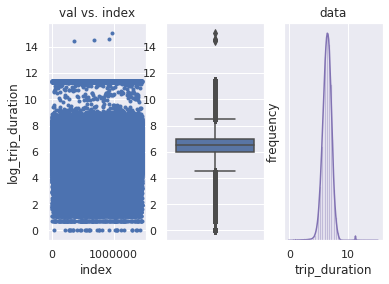

In [275]:
plt.subplot(131)
plt.plot(range(len(np.array(np.log(data['trip_duration'])))),np.array(np.log(data['trip_duration'])),'.');plt.ylabel('log_trip_duration');plt.xlabel('index');plt.title('val vs. index')
plt.subplot(132)
sns.boxplot(np.array(np.log(data['trip_duration'])),orient='v')
plt.subplot(133)
sns.distplot(np.array(np.log(data['trip_duration'])),bins=50, color="m");plt.yticks([]);plt.xlabel('trip_duration');plt.title('data');plt.ylabel('frequency')
#plt.hist(y,bins=50);

4개의 point만이 멀리있는것처럼 보인다. 다른 outlier들은 test set에도 일어날 수 있기 때문에 이 4개의 point만 outlier로 취급할것이다.

In [278]:
# trip_duration 을 로그변환한 값이 12보다 크면 outlier로 취급
outliers[np.array(np.log(data['trip_duration'])) >12]=True
print('There are %d entries that have trip duration too long'% sum(outliers))

There are 4 entries that have trip duration too long


* trip_duration이 너무 작은 경우 <br>
trip_duration이 1초이고, total_distance가 거의 0에 가까운 경우가 있는데, 이경우는 승객이 택시를 타려다가 마음을 바꿔서 그냥 걸어간 경우로 볼 수 있다.

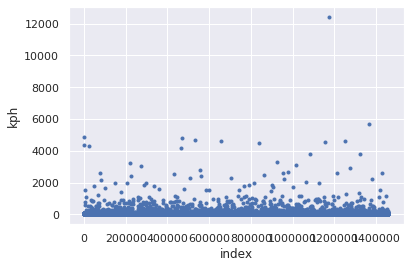

In [288]:
kph = osrm_data.total_distance/1000/data.trip_duration*3600
plt.plot(range(len(kph)),kph,'.');plt.ylabel('kph');plt.xlabel('index');plt.show()

보면, 1000km/hr 운전한 택시 기사가 많은 것을 알 수 있다. 많은 recording error로 볼 수 있음. <br>
만약 새로운 values를 예측하는것이라면 제거할것이지만, 여기서는 모두 가져갈 것이다.

### 2.2 Outliers from Locations
여기에는 pickup 과 dropoff두개의 location이 있다. outlier가 있는지 보려면, 이것들은 결합해서 boxplot으로 보여줄것이다.

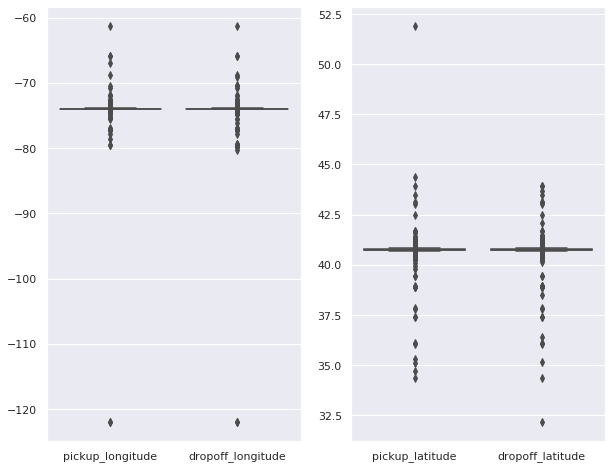

In [304]:
fig = plt.figure(figsize=(10,8))
for i,loc in enumerate((['pickup_longitude','dropoff_longitude'],['pickup_latitude','dropoff_latitude'])):
    plt.subplot(1,2,i+1)
    sns.boxplot(data=data[outliers==False],order=loc)

In [308]:
for i,loc in enumerate((['pickup_longitude','dropoff_longitude'],['pickup_latitude','dropoff_latitude'])):
    print(loc)

['pickup_longitude', 'dropoff_longitude']
['pickup_latitude', 'dropoff_latitude']


In [309]:
for i, feature in enumerate(['pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude']):
    print(feature)

pickup_longitude
pickup_latitude
dropoff_longitude
dropoff_latitude


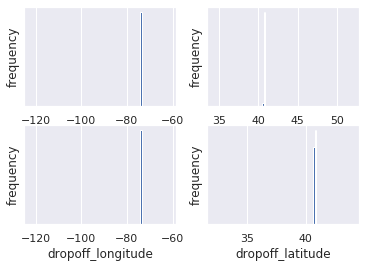

In [316]:
for i, feature in enumerate(['pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude']):
    plt.subplot(2,2,i+1)
    data[outliers==False][feature].hist(bins=100)
    plt.xlabel(feature)
    plt.ylabel('frequency')
    plt.yticks([])

In [317]:
import folium # goelogical map
map_1 = folium.Map(location=[40.767937,-73.982155 ],tiles='OpenStreetMap',
 zoom_start=12)
#tile: 'OpenStreetMap','Stamen Terrain','Mapbox Bright','Mapbox Control room'
for each in data[:1000].iterrows():
    folium.CircleMarker([each[1]['pickup_latitude'],each[1]['pickup_longitude']],
                        radius=3,
                        color='red',
                        popup=str(each[1]['pickup_latitude'])+','+str(each[1]['pickup_longitude']),
                        fill_color='#FD8A6C'
                        ).add_to(map_1)
map_1

In [319]:
print('I assign %d points as outliers' %sum(outliers))

I assign 4 points as outliers


-----------------
## 3. Analysis of Features

#### pickup_time vs trip_duration
pickup_time과 trip_duration에 대한 box whisker plot을 그려보자. <br>
'rush hour' 이론이 사실이란것을 보여준다.

In [323]:
# pickup시간 별 여행시간
tmpdata =data
tmpdata = pd.concat([tmpdata,time_data],axis=1)    # 시간 데이터와 기존 데이터 concat
tmpdata=tmpdata[outliers==False]

In [328]:
tmpdata['log_trip_duration']=np.log(tmpdata['trip_duration'])

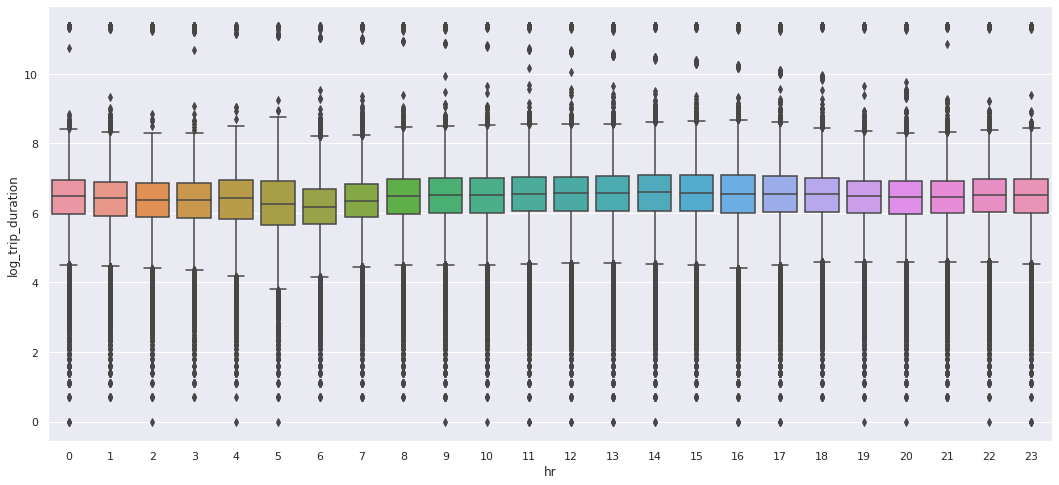

In [331]:
fig=plt.figure(figsize=(18,8))
sns.boxplot(x='hr',y='log_trip_duration',data=tmpdata)

#### month vs trip_duration
month와 trip_duration 에 같은 작업을 해보자. 이들은 매우 유사하게 보인다. rest_day가 아래와 같이 ploted되어있다.  <br>
보면, rest_day에 trip이 더 빠른것을 볼 수 있다. <br>
즉, 쉬는날 trip_duration이 짧은것

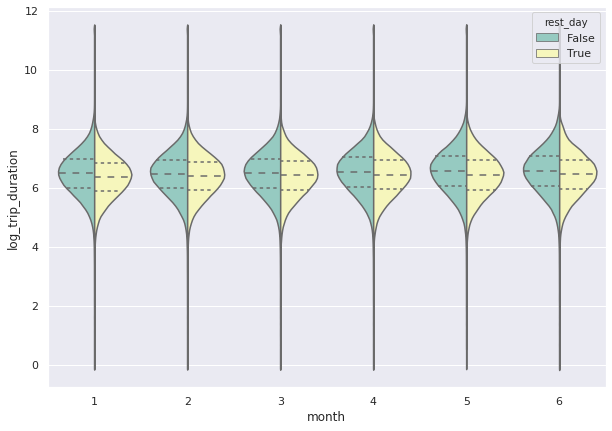

In [348]:
plt.figure(figsize=(10,7))
sns.violinplot(x='month',y='log_trip_duration', hue='rest_day', data=tmpdata, palette="Set3",split=True, inner='quart')

#### rest_day vs trip_duration
rest_day vs trip_duration에 차이가 있을 수 있다. 시간을 7AM 에서 9AM사이로 고정하면, <br>
rest day 인것과 아닌것에 큰 차이를 볼 수 있다. <br>
work day에 trip_duration의 중앙값이 더 높다.

In [339]:
tmpdata.head(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,left_steps,pickup_dropoff_loc,Temp.,Precip,snow,Visibility,rest_day,weekend,pickup_time,log_trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,...,1.0,6,4.4,0.3,0.0,8.0,False,False,17.400000,6.120297
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,...,2.0,8,28.9,0.0,0.0,16.1,True,True,0.716667,6.496775
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,...,4.0,4,-6.7,0.0,0.0,16.1,False,False,11.583333,7.661056


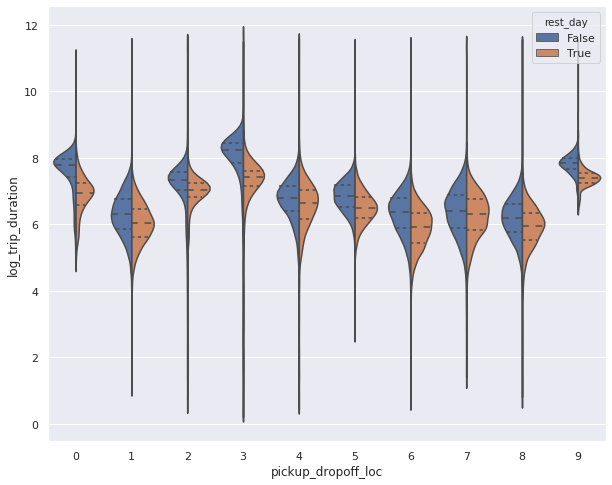

In [344]:
# pickup_time 조건을 아침 7시에서 9시 사이로 했을 때, 차이가 큼 
plt.figure(figsize=(10,8))
sns.violinplot(x='pickup_dropoff_loc',y='log_trip_duration', hue='rest_day', data=tmpdata[np.array(tmpdata.pickup_time>7) & np.array(tmpdata.pickup_time<9)],split=True,inner='quart' )

* x축을 pickup_dropoff_loc 으로 했을때
    * 위치별로 휴일여부에 따라 여행기간이 달라보임.

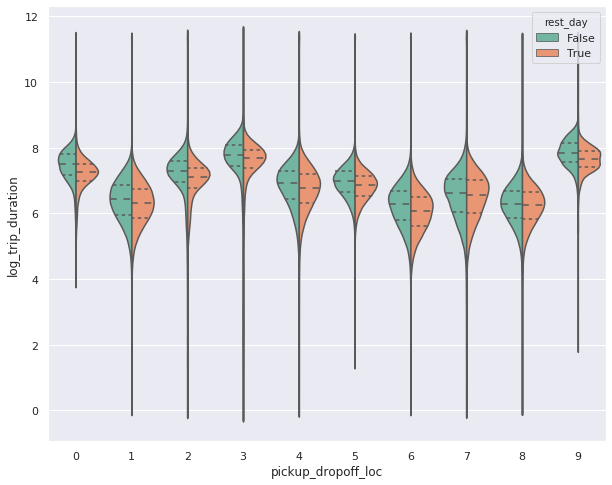

In [347]:
# pickup_time조건 안줘도 위치별 차이는 보임.
plt.figure(figsize=(10,8))
sns.violinplot(x='pickup_dropoff_loc',y='log_trip_duration', hue='rest_day', data=tmpdata,palette="Set2",split=True,inner='quart' )

--------------------------
## 4. XGB Model: the Prediction of trip_duration

In [350]:
mydf = data[['vendor_id','passenger_count','pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude','store_and_fwd_flag']]

testdf = test[['vendor_id','passenger_count','pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude','store_and_fwd_flag']]

In [351]:
print('There are %d samples in the test data'%len(testdf))

There are 625134 samples in the test data


kmean10_data 와 kmean10_test 데이터는 categorical(범주형) 이기 때문에, xgboost를 적용하기 위해서는 one-hot 인코딩으로 변환해줘야 한다. 

In [354]:
kmean_data=pd.get_dummies(kmean10_data.pickup_dropoff_loc, prefix='loc', prefix_sep='_')
kmean_test= pd.get_dummies(kmean10_test.pickup_dropoff_loc,prefix='loc', prefix_sep='_')  

In [359]:
mydf = pd.concat([mydf, time_data, weather_data, osrm_data, Other_dist_data, kmean_data], axis=1)
testdf= pd.concat([testdf,time_test,weather_test,osrm_test,Other_dist_test,kmean_test],axis=1)

In [373]:
# 배열의 각 원소들을 일일히 비교하는 것이 아니라, 배열의 모든 원소가 다 같은지 알고 싶다면 all 명령어 사용
if np.all(mydf.keys()==testdf.keys()):
    print('Good! The keys of training feature is identical to those of test feature')
else:
     print('Oops, something is wrong, keys in training and testing are not matching')  

Good! The keys of training feature is identical to those of test feature


### 4.1 Using XGBoost Module
* XGBoost는 Gradient Boost Machine(GBM)의 'accelerated'된 버전이다. 

* tree algorithm은 범주형을 다룰 수 있지만, sklearn 또는 xgboost는 그것을 numerical로 취급할것이다. <br>
그래서 categorical feature가 있다면 one-hot feature로 변환해야 한다.

------------
## About XGBoost 
[참고]  <br>
https://bcho.tistory.com/1354 <br>
https://apple-rbox.tistory.com/6 <br>
https://3months.tistory.com/368 <br>
[slide share] <br>
https://www.slideshare.net/freepsw/boosting-bagging-vs-boosting

XGBoost는 여러개의 Decision Tree를 조합해서 사용하는 Ensemble 알고리즘이다.  <br>
=> Ensemble은 방식에 따라서 Bagging과 Boosting으로 분류된다.

### Ensemble의 2가지 종류 Bagging and Boosting
* Ensemble은 여러개의 모델을 조합해서 그 결과를 뽑아내는 방법. 정확도가 높은 강한 모델을 하나 사용하는 것보다, <br>
정확도가 낮은 약한 모델을 여러개 조합하는 방식이 정확도가 높다는 방법에 기반한 방법

> **Bagging** <br>
여러 모델을 사용할 때, 각 모델에서 나온 값을 계산하여 최종 결과값을 내는 방식. <br>
예를들어 모델 m1,m2,m3 모델이 있을 때 입력 데이터 X를 모델 m1,m2,m3에 넣고 그 결과값을 받아서 <br>
합산 (또는 평균 등) 해서, 최종결과를 취하는 방식. <br>
모델 m1~m3 로 데이터를 넣을 때는 원본 데이터 x에서 매번 다시 샘플링해서 다른 샘플 데이터를 각각 모델에 넣는 방식. 

<img src="bagging.PNG" width="300"> <br>

> **Boosting** <br>
m1,m2,m3 모델이 있을 때, m1에는 x에서 샘플링된 데이터를 넣는다. <br>
그리고 나온 결과중에서 예측이 잘못된 x값들에 가중치를 반영해서 다음 모델인 m2에 넣는다. <br>
마찬가지로 y2결과에서 예측이 잘못된 x'값들에 가중치를 반영해서 m3에 넣는다. <br>
그리고 각 모델의 성능이 다르기 때문에 각 모델에 가중치 W를 반영한다.

<img src="boosting.PNG" width="300"> <br>


**CART (Classification And Regression Trees)** <br>
> CART의 원리 : Additive learning 으로, '의사결정 나무 모델을 여러 개 학습시켜서 예측값을 더한 것으로 결정하겠다' 
* 이렇게 더해진 예측 점수들을 이용해 결론을 내림으로서 과적합이나 기존 모델이 잘 설명하지 못하는 취약 부분에 대한 보완을 할 수 있는 힘을 만든다.
<br>

**하이퍼 파라미터와 XGBoost** <br>
regularizationn term(모델 복잡도), learning rate등을 사용자가 설정해 줘야 함. <br>
learning rate가 높을 수록 빠르게 모델의 bias를 줄여나가지만, learning rate가 적으면 디테일한 부분을 놓칠 수 있다. 

> * eta : learning rate, default = 0.3 [0,1]
    * eta는 'Step size shrinkage'로 학습 단계별로 가중치를 얼마나 적용할 지 결정하는 숫자. 
    낮을수록 보수적인 모델이 된다. (다음 단계의 결과물을 적게 반영하기 때문)
* gamma : min split loss, default = 0, [0,무한대]
    * Gamma를 이해하기 위해서는 먼저 information gain이라는 것을 이해해야 한다. 
        * information gain은 의사결정나무가 가지를 칠 때, 즉 새로운 변수를 기준으로 데이터를 분류할 때 타겟 변수에 대해 얼마나 설명할 수 있는지를 측정하는 기준.
    * Gamma는 계산한 information gain에 패널티를 부여하는 숫자. <br>
    즉, 이값이 커질수록 의사결정나무들은 가지를 잘 만들려 하지 않게 되며, 이에 따라 보수적인 모델이 된다.
* max_depth : default = 6
    * 의사결정나무의 깊이의 한도. 커질수록 더 복잡한 모델이 생성되며, 이는 overfitting의 문제를 일으킬 수 있다. 
* subsample : default=1
    * training데이터셋에서 subset을 만들지, 전부를 사용할지 정하는 파라미터.<br>
    매번 나무를 만들 때 적용하며 overfitting문제를 방지하려고 사용.
* colsample_bytree : default=1
    * 나무를 만들 때 칼럼, 즉 변수를 샘플링해서 쓸지에 대한 파라미터. <br>
    나무를 만들기 전 한 번 샘플링을 하게 됨.
* scale_pos_weight : default=1
    * 분류 모델에서 사용하는 가중치 파라미터로, 극단적으로 적은 타겟값이 존재하는 문제에서 유용.
    
-----------

In [377]:
import xgboost as xgb

In [ ]:
X = mydf[Out.outliers==False]
z = data[Out.outliers==False].log_trip_duration.values

In [ ]:
# 샙플 50000개 데이터 사용
X = X[:50000]
z = z[:50000]

In [395]:
X = mydf[:50000]
z = data['log_trip_duration'][:50000]

In [397]:
from sklearn.model_selection import train_test_split

# train-set과 test-set을 8대2로 나누고
Xtrain, Xval, Ztrain, Zval = train_test_split(X, z, test_size=0.2, random_state=0)

# 위에서 나눈 20% 비율의 데이터를 다시나눔.
Xcv,Xv,Zcv,Zv = train_test_split(Xval, Zval, test_size=0.5, random_state=1)
data_tr = xgb.DMatrix(Xtrain, label=Ztrain)    # 첫번째 나눈 set
data_cv = xgb.DMatrix(Xcv, label=Zcv)    # 두번째 나눈 set

evallist = [(data_tr,'train'), (data_cv, 'valid')]

### XGBoost 파라미터
http://okminseok.blogspot.com/2017/09/ml-xgboost.html

#### Booster Parameters
* eta [default=0.3] => learning_rate
   - GBM의 학습 속도와 유사.
   - 각 단계에서 가중치를 줄임으로써 모델을 더 강건하게 만든다.
   - 일반적으로 0.01-0.2
* min_child_weight [default=1] (Should be tuned using CV)
   - child의 관측(?)에서 요구되는 최소 가중치의 합
   - over-fitting vs under-fitting을 조정하기 위한 파라미터.
   - 너무 큰 값이 주어지면 under-fitting.
* max_depth [default=6] (Should be tuned using CV)
   - 트리의 최대 깊이.
   - 일반적으로 3-10
* max_leaf_nodes
   - 최종 노드의 최대 개수. (max number of terminal nodes)
   - 이진 트리가 생성되기 때문에 max_depth가 6이면 max_leaf_nodes는 2^6개가 됨.
* subsample [default=1]
   - 각 트리마다의 관측 데이터 샘플링 비율.
   - 값을 적게 주면 over-fitting을 방지하지만 값을 너무 작게 주면 under-fitting.
   - 일반적으로 0.5-1
* colsample_bytree [default=1]
   - 각 트리마다의 feature 샘플링 비율.
   - 일반적으로 0.5-1
* lambda [default=1] => reg_lambda
   - 가중치에 대한 L2 정규화 용어 (Ridge 회귀 분석과 유사(?))

#### Learning Task Parameters : 각 단계에서 계산할 최적화 목표를 정의하는 데 사용된다.
* objective [default=reg:linear]
   - binary:logistic : 이진 분류를 위한 로지스틱 회귀, 예측된 확률을 반환한다. (not class)
   - multi:softmax : softmax를 사용한 다중 클래스 분류, 예측된 클래스를 반환한다. (not probabilities)
   - multi:softprob : softmax와 같지만 각 클래스에 대한 예상 확률을 반환한다.

In [401]:
parms = {'max_depth':8, #maximum depth of a tree
         'objective':'reg:linear',
         'eta'      :0.3,
         'subsample':0.8,#SGD will use this percentage of data
         'lambda '  :4, #L2 regularization term,>1 more conservative 
         'colsample_bytree ':0.9,
         'colsample_bylevel':1,
         'min_child_weight': 10,
         'nthread'  :3}  #number of cpu core to use

model = xgb.train(parms, data_tr, num_boost_round=1000, evals=evallist,
                 early_stopping_rounds=30, maximize=False,
                 verbose_eval=100)

print('score=%1.5f, n_boost_round=%d.' %(model.best_score, model.best_iteration))

[09:22:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:4.22427	valid-rmse:4.22765
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.
Stopping. Best iteration:
[26]	train-rmse:0.341273	valid-rmse:0.459982

score=0.45998, n_boost_round=26.


더 좋은 score를 원하는 사람은, 아래를 조정해보면된다. <br>
1. Using lower eta
2. Using lower min_child_weight
3. Using larger max_depth

그리고 cross validation을 돌려봐라.

### 4.2 The Submission

In [403]:
data_test = xgb.DMatrix(testdf)
ztest = model.predict(data_test)

z 를 다시 y로 전환

In [405]:
ytest = np.exp(ztest)-1
print(ytest[:10])

[ 774.86304  511.54694  392.50015  889.53204  282.27673  890.51776
 1987.677    878.0485  2769.5435   578.14325]


In [409]:
submission=pd.DataFrame({'id':test.id, 'trip_duration':ytest})
# submission.to_csv('submission.csv', index=False)

### 4.3 Importance for each Feature
[참고] https://aldente0630.github.io/data-science/2018/12/10/interpretable_ml_with_xgb.html <br>

중요도는 아래에 의해 계산된다. <br>
1. tree를 만들기 위해 선택된 feature의 개수
2. loss function 관점에서 tree를 만들기 위해 feature를 사용하는 데 있어서 얻은 것.

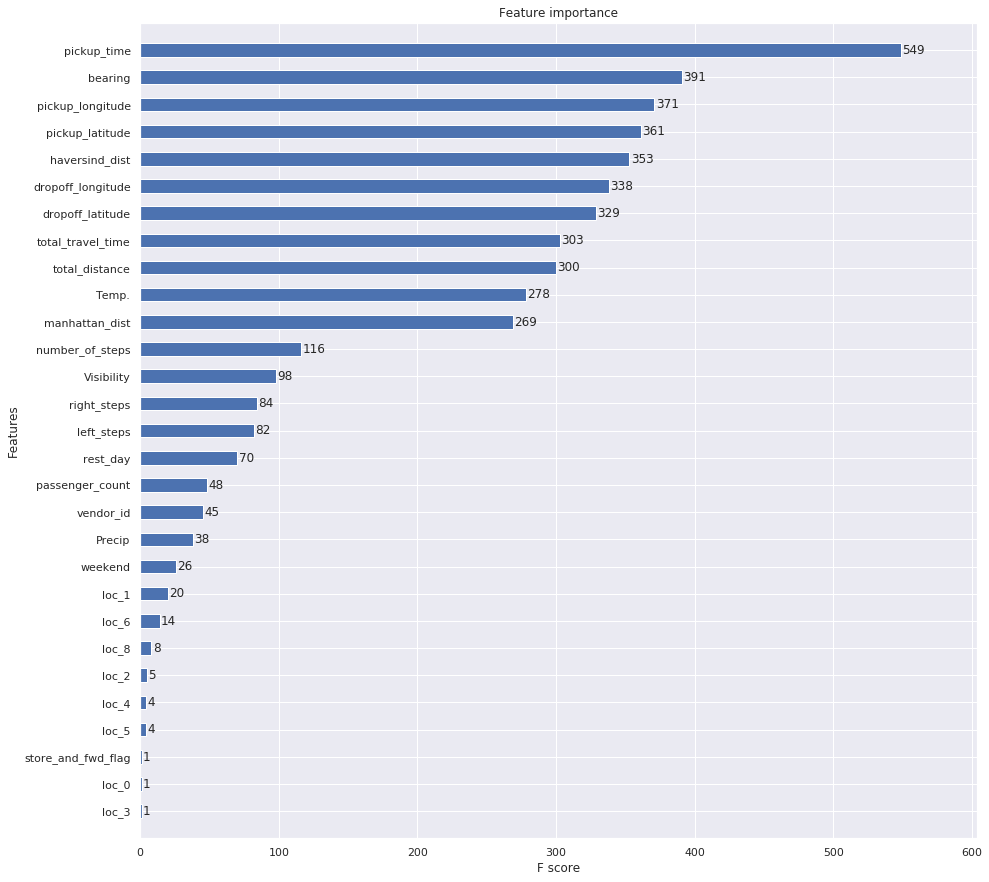

In [410]:
fig =plt.figure(figsize=(15,15))
axes=fig.add_subplot(111)
xgb.plot_importance(model, ax=axes, height=0.5)
plt.show();plt.close()

pickup_time이 가장 중요한 feaure로 보인다. rush hour가 trip duration에 심하게 영향을 미칠것이다. <br>
haversind_dist, total_distance 그리고 manhatten_dist와 같은 몇몇 거리와 관련된 feature들도 영향이 큰것으로 보인다. <br>
OSRM데이터로 부터 얻은 total_travel_time 도 영향이 크다.

[인상적인 결과]
1. Temp. : 온도가 중요한 feature로 나온것. 이론상으로는, 너무 춥거나 더우면 사람들이 바깥에 걷기를 싫어할것이라고 생각이됨.
2. K-means location 이 중요하게 나오지 않은 것. 아마도 분류를 너무 많은 수로 해서 그렇다고 예상.
3. workday와 restday 가 영향을 많이 미칠것이라고 생각했지만, 중요도에서는 떨어졌음. <br>
아마도 rest_day 와 weekend 가 매우 비슷한 feature라서 결과가 희석된 것으로보임.